<a href="https://colab.research.google.com/github/yasinsoylu1997/lstm-nlp/blob/main/nlp_LSTM_MODELL_ipynb_adl%C4%B1_not_defterinin_kopyas%C4%B1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, GRU, Embedding, CuDNNGRU
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
import re
from sklearn.model_selection import train_test_split 
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import nltk

from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [ ]:
dataset = pd.read_csv('out.csv')

In [ ]:
dataset

,yildizSayisi,yorum,yorumLike,yorumDislike
0,5,I bought this mouse for my home computer and i...,14,4
1,5,Ürünü yaklaşık 3 aydır kullanıyorum. Hem ergon...,6,0
2,5,"Teknolojiden çok anlayan biri değilim, sadece ...",1,0
3,5,Perfect,3,0
4,5,"Ürünün yapısı oldukça ergonomik, işte kullanma...",2,0
...,...,...,...,...
479237,1,Bana hiç iyi gelmedi dökülmeyi durdurmadığı gi...,4,4
479238,5,Ürünler bir gün içinde elimdeydi.teşekkürler..,3,6
479239,1,Arkadaşlar ben aldım 1 ay kullandım saç dökülm...,10,27
479240,3,Saç dökülmesi konusunda herhangi bir şampuanda...,10,3


In [ ]:
dataset.dropna()

,yildizSayisi,yorum,yorumLike,yorumDislike
0,5,I bought this mouse for my home computer and i...,14,4
1,5,Ürünü yaklaşık 3 aydır kullanıyorum. Hem ergon...,6,0
2,5,"Teknolojiden çok anlayan biri değilim, sadece ...",1,0
3,5,Perfect,3,0
4,5,"Ürünün yapısı oldukça ergonomik, işte kullanma...",2,0
...,...,...,...,...
479237,1,Bana hiç iyi gelmedi dökülmeyi durdurmadığı gi...,4,4
479238,5,Ürünler bir gün içinde elimdeydi.teşekkürler..,3,6
479239,1,Arkadaşlar ben aldım 1 ay kullandım saç dökülm...,10,27
479240,3,Saç dökülmesi konusunda herhangi bir şampuanda...,10,3


In [ ]:
dataset["yildizSayisi"] = dataset.yildizSayisi.astype(float)


In [ ]:
def sentiments(df):
  if df['yildizSayisi'] > 3.9:
    return 'Positive'
  elif df['yildizSayisi'] <= 3.0:
    return 'Negative'
dataset['sentiment'] = dataset.apply(sentiments, axis=1)

In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 479242 entries, 0 to 479241
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   yildizSayisi  479242 non-null  float64
 1   yorum         479242 non-null  object 
 2   yorumLike     479242 non-null  int64  
 3   yorumDislike  479242 non-null  int64  
 4   sentiment     479242 non-null  object 
dtypes: float64(1), int64(2), object(2)
memory usage: 18.3+ MB


In [ ]:
dataset

,yildizSayisi,yorum,yorumLike,yorumDislike,sentiment
0,5.0,I bought this mouse for my home computer and i...,14,4,Positive
1,5.0,Ürünü yaklaşık 3 aydır kullanıyorum. Hem ergon...,6,0,Positive
2,5.0,"Teknolojiden çok anlayan biri değilim, sadece ...",1,0,Positive
3,5.0,Perfect,3,0,Positive
4,5.0,"Ürünün yapısı oldukça ergonomik, işte kullanma...",2,0,Positive
...,...,...,...,...,...
479237,1.0,Bana hiç iyi gelmedi dökülmeyi durdurmadığı gi...,4,4,Negative
479238,5.0,Ürünler bir gün içinde elimdeydi.teşekkürler..,3,6,Positive
479239,1.0,Arkadaşlar ben aldım 1 ay kullandım saç dökülm...,10,27,Negative
479240,3.0,Saç dökülmesi konusunda herhangi bir şampuanda...,10,3,Negative


In [ ]:
dataset['yorum'] = dataset['yorum'].apply(lambda x: x.lower())
dataset['yorum'] = dataset['yorum'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

In [ ]:
print(dataset[ dataset['sentiment'] == 'Positive'].size)
print(dataset[ dataset['sentiment'] == 'Negative'].size)

2171905
224305


In [ ]:
data_pos = dataset[ dataset['sentiment'] == 'Positive']
data_pos = dataset['yorum']
data_neg = dataset[ dataset['sentiment'] == 'Negative']
data_neg = dataset['yorum']

In [ ]:
def wordcloud_draw(dataset, color = 'black'):
    words = ' '.join(dataset)
    cleaned_word = " ".join([word for word in words.split()
                            if 'http' not in word
                                and not word.startswith('@')
                                and not word.startswith('#')
                                and word != 'RT'
                            ])
    wordcloud = WordCloud(stopwords=STOPWORDS,
                      background_color=color,
                      width=2500,
                      height=2000
                     ).generate(cleaned_word)
    plt.figure(1,figsize=(13, 13))
    plt.imshow(wordcloud)
    plt.axis('off')
    plt.show()

In [ ]:
print("Positive words")
wordcloud_draw(data_pos,'white')

Positive words


In [ ]:
print("Negative words")
wordcloud_draw(data_neg)

Negative words


In [ ]:
dataset

,yildizSayisi,yorum,yorumLike,yorumDislike,sentiment
0,5.0,i bought this mouse for my home computer and i...,14,4,Positive
1,5.0,rn yaklak 3 aydr kullanyorum hem ergonomik tas...,6,0,Positive
2,5.0,teknolojiden ok anlayan biri deilim sadece kii...,1,0,Positive
3,5.0,perfect,3,0,Positive
4,5.0,rnn yaps olduka ergonomik ite kullanmak iin al...,2,0,Positive
...,...,...,...,...,...
479237,1.0,bana hi iyi gelmedi dklmeyi durdurmad gibi sal...,4,4,Negative
479238,5.0,rnler bir gn iinde elimdeyditeekkrler,3,6,Positive
479239,1.0,arkadalar ben aldm 1 ay kullandm sa dklme kart...,10,27,Negative
479240,3.0,sa dklmesi konusunda herhangi bir ampuandan fa...,10,3,Negative


In [ ]:
data = dataset[['yorum','sentiment']]
target = dataset['sentiment'].values

In [ ]:
data

,yorum,sentiment
0,i bought this mouse for my home computer and i...,Positive
1,rn yaklak 3 aydr kullanyorum hem ergonomik tas...,Positive
2,teknolojiden ok anlayan biri deilim sadece kii...,Positive
3,perfect,Positive
4,rnn yaps olduka ergonomik ite kullanmak iin al...,Positive
...,...,...
479237,bana hi iyi gelmedi dklmeyi durdurmad gibi sal...,Negative
479238,rnler bir gn iinde elimdeyditeekkrler,Positive
479239,arkadalar ben aldm 1 ay kullandm sa dklme kart...,Negative
479240,sa dklmesi konusunda herhangi bir ampuandan fa...,Negative


In [ ]:
data['yorum'] = data['yorum'].apply(lambda x: x.lower())
data['yorum'] = data['yorum'].apply((lambda x: re.sub('[^a-zA-z0-9\s]','',x)))

print(data[ data['sentiment'] == 'Positive'].size)
print(data[ data['sentiment'] == 'Negative'].size)

for idx,row in data.iterrows():
    row[0] = row[0].replace('rt',' ')
    
max_fatures = 2000
tokenizer = Tokenizer(num_words=max_fatures, split=' ')
tokenizer.fit_on_texts(data['yorum'].values)
X = tokenizer.texts_to_sequences(data['yorum'].values)
X = pad_sequences(X)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


868762
89722


In [ ]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)

In [ ]:
cutoff = int(len(data) * 0.80)
x_train, x_test = data[:cutoff], data[cutoff:]
y_train, y_test = target[:cutoff], target[cutoff:]

In [ ]:
num_words = 10000
tokenizer = Tokenizer(num_words=num_words)

In [ ]:
tokenizer.fit_on_texts(data)
x_train_tokens = tokenizer.texts_to_sequences(x_train)

In [ ]:
tokenizer.fit_on_texts(data)
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [ ]:
num_tokens = [len(tokens) for tokens in x_train_tokens + x_test_tokens]
num_tokens = np.array(num_tokens)

In [ ]:
max_tokens = np.mean(num_tokens) + 2 * np.std(num_tokens)
max_tokens = int(max_tokens)
max_tokens

1

In [ ]:
x_train_pad = pad_sequences(x_train_tokens, maxlen=max_tokens)

x_test_pad = pad_sequences(x_test_tokens, maxlen=max_tokens)



In [ ]:
x_train_tokens = tokenizer.texts_to_sequences(x_train)

In [ ]:
x_test_tokens = tokenizer.texts_to_sequences(x_test)

In [ ]:
idx = tokenizer.word_index
inverse_map = dict(zip(idx.values(), idx.keys()))

In [ ]:
def tokens_to_string(tokens):
    words = [inverse_map[token] for token in tokens if token!=0]
    text = ' '.join(words)
    return text

In [ ]:
from tensorflow.keras.optimizers import SGD
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, MaxPooling1D, Bidirectional, LSTM, Dense, Dropout , LSTM, SpatialDropout1D
from keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import  RMSprop
from keras import datasets
from keras.callbacks import LearningRateScheduler
from keras.callbacks import History
from keras import losses


In [ ]:
max_len=280

model = Sequential()
embedding_size = 50

model.add(Embedding(input_dim=num_words,
                    output_dim=embedding_size,
                    input_length=max_len,
                    name='embedding_layer'))

model.add(Conv1D(filters=32, kernel_size=3, padding='same', activation='relu'))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(32))
model.add(Dropout(0.5))
model.add(Dense(2, activation='sigmoid'))

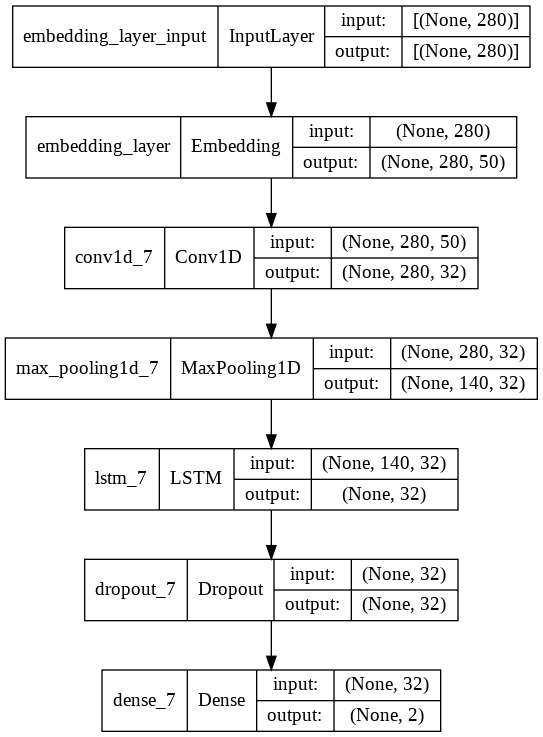

In [ ]:
import tensorflow as tf
tf.keras.utils.plot_model(model, show_shapes=True)

In [ ]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy', Precision(), Recall()])

In [ ]:
Y = pd.get_dummies(data['sentiment']).values
X_train, X_test, Y_train, Y_test = train_test_split(X,Y, test_size = 0.3, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(335469, 280) (335469, 2)
(143773, 280) (143773, 2)


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=2)

In [260]:
history=model.fit(X_train, Y_train, epochs=20, batch_size=512,validation_split=0.1,callbacks=[callback])

Epoch 1/20
590/590 [==============================] - 252s 427ms/step - loss: 0.1720 - accuracy: 0.9383 - precision_7: 0.9386 - recall_7: 0.9374 - val_loss: 0.1659 - val_accuracy: 0.9387 - val_precision_7: 0.9389 - val_recall_7: 0.9387
Epoch 2/20
590/590 [==============================] - 252s 426ms/step - loss: 0.1596 - accuracy: 0.9430 - precision_7: 0.9429 - recall_7: 0.9430 - val_loss: 0.1623 - val_accuracy: 0.9407 - val_precision_7: 0.9401 - val_recall_7: 0.9415
Epoch 3/20
590/590 [==============================] - 251s 426ms/step - loss: 0.1522 - accuracy: 0.9457 - precision_7: 0.9454 - recall_7: 0.9459 - val_loss: 0.1608 - val_accuracy: 0.9407 - val_precision_7: 0.9406 - val_recall_7: 0.9410
Epoch 4/20
590/590 [==============================] - 251s 426ms/step - loss: 0.1449 - accuracy: 0.9490 - precision_7: 0.9488 - recall_7: 0.9490 - val_loss: 0.1563 - val_accuracy: 0.9426 - val_precision_7: 0.9423 - val_recall_7: 0.9428
Epoch 5/20
590/590 [==============================] - 24

In [ ]:
 score = model.evaluate(X_test, Y_test,batch_size=512)


281/281 [==============================] - 35s 124ms/step - loss: 0.1855 - accuracy: 0.9280 - precision_7: 0.9384 - recall_7: 0.9139


In [ ]:
print('Test loss:', score[0]) 
print('Test accuracy:', score[1])

Test loss: 0.1855493038892746
Test accuracy: 0.9280254244804382
